# Natural Language Processing: Vectorisation & Feature Representation

In the previous post, we discussed and implemented the first step in an NLP project pipeline: pre-processing the text data. We also had a look at the justification behind each substep and the importance of exercising caution given the context of the project we are pursuing.

Once our data is cleaned and processed, we can start to think about how to turn text into machine-readable inputs. That is the essence of feature representation. It is the method by which we map words to numbers, but in a way that allows the words to retain some inherent 'meaning' that is conducive to useful analysis. It will not be very useful, for example, to assign the word 'bad' the number '1', the word 'blue' the number '2' because there isn't anything about those numbers that uniquely links them to those specific words. In other words, we don't have a better justification for linking '1' to 'bad' then we do for linking '1' to 'blue' instead.

Luckily, there are several methods available to us that do link words and numbers in a meaningful way:

- Bag of Words (BOW)
- Term Frequency Inverse Document Frequency (TF-IDF)
- Word Embeddings
- Embeddings from Language Models (ELMo)

Let's examine each method in turn

## 1) Bag of Words (BOW) using Scikit Learn

The simplest approach to turn words into numbers, the BOW method is best explained using a short example. Suppose our data set has 3 reviews and 100 total unique words. For the first review, BOW will create a 100 column by 1 row vector, as the number of columns is equal to the number of unique words. For each word that occurs both in this latter list and the single review, BOW assigns a value of '1'. For each word that does not overlap, a value of '0' is assigned. This process is repeated for the 2nd and 3rd reviews


How does this help us? The intuition is that documents are similar if they have similar content. Further, that from the content alone we can learn something about the meaning of the document. And the gauge of similarity we are using here is the word overlap. So, if the first two reviews contain the word 'great' and are labelled as having a 'positive sentiment', our algorithms may 'learn' that 'great' is associated with a positive sentiment.

Let's split our data into training and test sets, run the pre-processing from the previous post and use scikit learn's CountVectorizer() to create a BOW for our Amazon product data

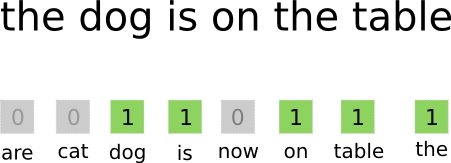

In [39]:
Image(filename = '/Users/alitaimurshabbir/Desktop/Personal/GitHub/Sentiment NLP & Analysis/img/BOW.png')

image via [gk_- Medium](https://machinelearnings.co/text-classification-using-neural-networks-f5cd7b8765c6)

In [1]:
import numpy as np
import random
import pandas as pd

#Pre-processing related
import nltk
import spacy
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import textblob, string

from sklearn import model_selection

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alitaimurshabbir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_json('/Users/alitaimurshabbir/Desktop/Personal/GitHub/Sentiment NLP & Analysis/reviews_Video_Games_5.json', lines=True)
data.drop(['asin','unixReviewTime', 'reviewTime'], axis = 1, inplace = True) #drop unnecessary columns
data.head(2) #preview data

,reviewerID,reviewerName,helpful,reviewText,overall,summary
0,A2HD75EMZR8QLN,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.
1,A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game


In [5]:
#quick pre-processing

def clean(text):
    text = "".join([char for char in text if char not in string.punctuation]) #remove punctuations
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", text).split()) #remove punctuations again
    text = re.sub('[0-9]+', '', text) #remove numbers
    text = ' '.join(re.sub( "(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", ' ', text ).split()) #remove hashtags and mentions
    text = ' '.join(re.sub("(\w+:\/\/\S+)", " ", text).split()) #remove URLs
    text = text.lower() #lower-case the text
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) #lemmatising
    return text

data['reviewText'] = data['reviewText'].apply(lambda x: clean(x))

In [6]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(data['reviewText'], data['overall'], test_size = 0.3, shuffle = True, random_state = 42)

In [31]:
print(X_train[0])
print(y_train[0])

installing the game wa a struggle because of game for window live bugssome championship race and car can only be unlocked by buying them a an addon to the game i paid nearly dollar when the game wa new i dont like the idea that i have to keep paying to keep playingi noticed no improvement in the physic or graphic compared to dirt i tossed it in the garbage and vowed never to buy another codemasters game im really tired of arcade style rallyracing game anywayill continue to get my fix from richard burn rally and you should to httpwwwamazoncomrichardburnsrallypcdpbcrefsrieutfqidsrkeywordsrichardburnsrallythank you for reading my review if you enjoyed it be sure to rate it a helpful
1


Below, you can see a single review and the number count of unique words it contains

In [8]:
print(X_train[2])
print(X_train_count[2].sum())

st shipment received a book instead of the gamend shipment got a fake one game arrived with a wrong key inside on sealed box i got in contact with codemasters and send them picture of the dvd and the content they said nothing they can do it a fake dvdreturned it good bye
25


One major downside of a BOW matrix is that it creates sparse vectors which makes computations resource-intensive, particularly with large datasets. It is also a very simplistic way of feature extraction. We will compare how well this method of feature representation does in terms of model performance later. Let's set this aside for now and move onto the next method.

## 2) Term Frequency-Inverse Document Frequency (TF-IDF) using Scikit Learn

TF-IDF is a very useful 'upgrade' applied to the BOW method. Here's how [MonkeyLearn](https://monkeylearn.com/blog/what-is-tf-idf/) describes it:



"*TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.*"

So, if a word occurs frequently in a single review, but rarely in the whole corpus of text of all reviews, then it's likely that that word is pretty relevant to that single review. TF-IDF allows us to capture this connection and gives more weight to such words. There is a specific mathematical formula used to calculate it, but we won't cover that here.

Another interesting thing to note is that we can apply the TF-IDF method to phrases or **n-grams**; we are not just confined to single words. This means we can compare how often a phrase occurs in a single review and compare that to how often it occurs in the whole body of text. This may help us in sentiment analysis because phrases might be more conducive to capturing sentiment than single words. 

Therefore, we will execute both word- and phrase-level TF-IDF vectorisation

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer #import TF-IDF Vectoriser

#tf-idf word-level vectorisation
TFIDF_vectoriser = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
TFIDF_vectoriser.fit(data['reviewText']) #fit the vectoriser onto our vocabulary

#transform our text data and store them within variables
X_train_tfidf = TFIDF_vectoriser.transform(X_train)
X_val_tfidf = TFIDF_vectoriser.transform(X_val)

#tf-idf n-gram level vectorisation. We define a phrase to be 3-words long

TFIDF_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(3,3), max_features=5000)
TFIDF_vect_ngram.fit(data['reviewText']) #fit the vectoriser onto our vocabulary

#transform X_train and X_val and store in separate variables 
X_train_tfidf_ngram =  TFIDF_vect_ngram.transform(X_train)
X_val_tfidf_ngram =  TFIDF_vect_ngram.transform(X_val)


As before, we set these features aside for now and move onto the next feature representation method

## 3) Word Embeddings (Word2Vec & GloVe)

This is where things start to get really interesting. Rather than basic counts of what words/phrases appear in a single review vs all reviews, we are able to capture some actual semantic and mathematical association between words using word embeddings.

Let's reiterate some important points before explaining word embeddings.

As described before, word vectors are numerical representations of words. Each vector (for a given word) can be thought of as a row with real numbers. With simpler approaches like BOW, we have seen that these vectors have binary values (1s and 0s). 

With Word Embeddings and more advanced methods, these vectors have real number values. Using this method, **we can map words in the vector space and use mathematical operations to get to other words**. Similar words are clustered closer together while different words are further apart. The classic example here is: **king - man + woman = queen**. We can actually get to queen because of the way these words are mapped numerically in the vector space.

In the image below, on the left, all 4 words have been mapped to a vector space. If we subtract the 'man' vector from the 'king' vector and add the 'woman' vector, we will get to the 'queen' vector.

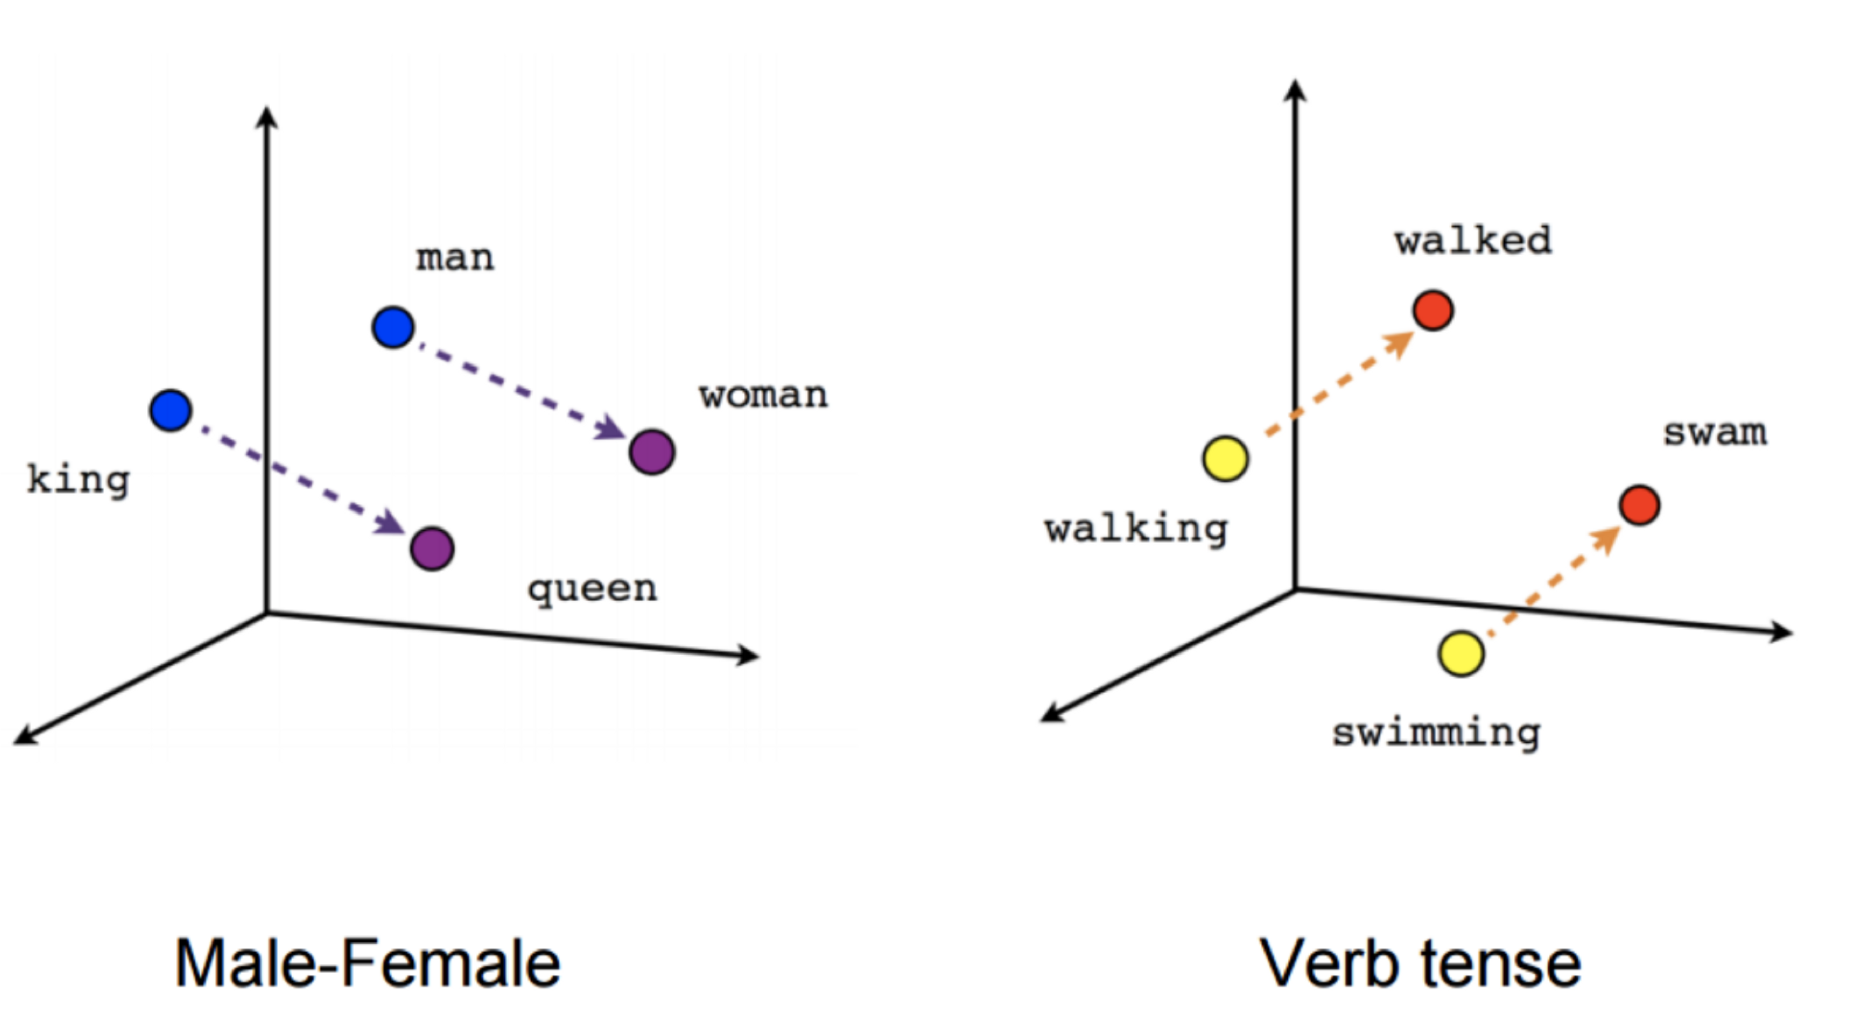

In [11]:
from IPython.display import Image
Image(filename = '/Users/alitaimurshabbir/Desktop/Personal/GitHub/Sentiment NLP & Analysis/img/Picture 1.png', width = 500, height = 500)

How is this possible? How can we come up with vectors that capture, among other things, that 'king' and 'man' (let us call this pair 'A') are similar, 'woman' and 'queen' are similar ('B') but 'A' and 'B' are different?

Well, it has to idea with the basic idea of distributional semantics which can be summed up in the so-called distributional hypothesis: linguistic items with similar distributions have similar meanings. The meaning of a word is given by the words that frequently appear close to it. 

In other words, "you shall know a word by the company (context) it keeps" - J.R. Firth

Let's look at a specific model called **Word2Vec** for better understanding. Word2Vec is actually a 2-layer shallow neural network. This means it has only 1 hidden layer. Using the image below as a visual guide, we can explain how Word2Vec functions

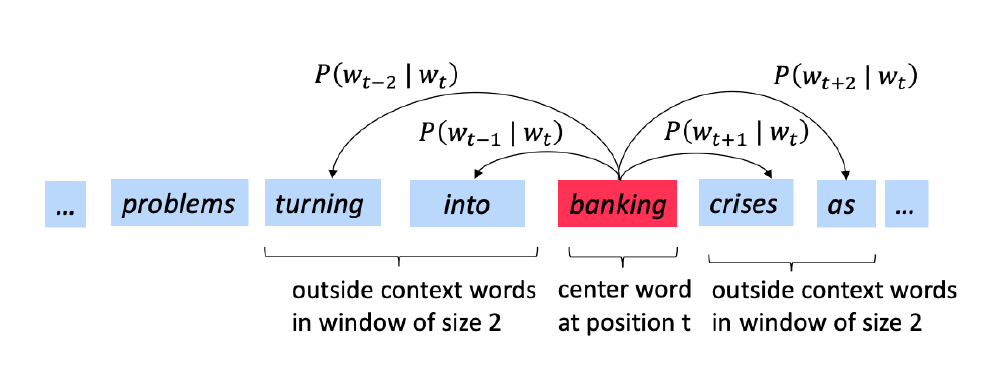

In [12]:
from IPython.display import Image
Image(filename = '/Users/alitaimurshabbir/Desktop/Personal/GitHub/Sentiment NLP & Analysis/img/Picture 2.png')

1. Represent each word in a sentence as a fixed vector
2. Let one word, the first one, be your 'centre' c and identify the context or outer words o
3. Repeat this process by iterating through the text and making each word the centre word
4. Find the probability of c given o or vice versa, as stated by the conditional probability expressions in the image
5. Adjust size of context window and repeat steps 1 through 4
5. Adjust resulting vectors to maximise probability in step 4


Word2Vec actually comes in 2 flavours, **Continuous Bag of Words (CBOW)** and **Skip-grams**. Here is a very condensed explanation of how they differ and the contexts in which they are more suitable to be used:

In CBOW, we predict c from a bag of context words. CBOW is several times faster than skip-grams and provides a better frequency for frequent words

In skip-grams, we predict the position of outside words independent of position, given c. Skip-grams needs a small amount of training data and represents even rare words or phrases

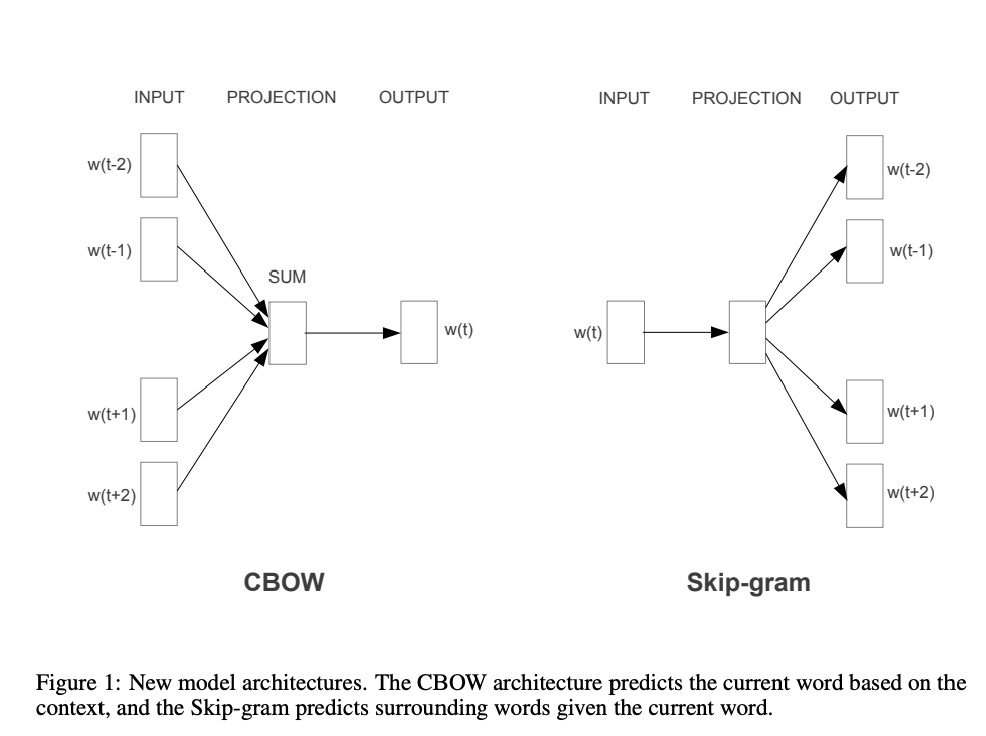

In [13]:
Image(filename = '/Users/alitaimurshabbir/Desktop/Personal/GitHub/Sentiment NLP & Analysis/img/Picture 3.png')

An alternative to Word2Vec in creating word embeddings is **Global Vectors for Word Representation** or **GloVe**. It is a weighted least squares model that trains on global word-word co-occurrence counts, as opposed to Word2Vec which focuses on a local sliding window around each word to generate vectors. 

The mechanism behind how GloVe works is pretty technical, and since I want to keep this post focused on a mix between explanation and implementation, I'll refer you to this excellent [article](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010) by Thushan Ganegedara on Medium for a more detailed explanation

One advantage of GloVe is that we have access to pre-trained word vectors available, trained on various corpora (bodies of text). This can become exceedingly handy depending on how unique our text domain is. For instance, people write on Twitter in a very unique style. If we had text data from Twitter that we wanted to analyse, then using Twitter-trained word vectors may result in better model performance. 

For more general domains, we can always use more general word vectors. Wikipedia-trained word vectors could be a good approximation to use for general tasks. That's what we will do now.

To begin, we need access to a txt file containing these embeddings. The file I use contains 300-dimensional word vectors trained on 6 billion tokens

In [15]:
globe_path = "/Users/alitaimurshabbir/Desktop/Personal/Coca Cola/Word Embedding Models/glove.6B/glove.6B.300d.txt" #set path

#load GloVe word embeddings
def load_word_embeddings(file=globe_path):
    embeddings={}
    with open(file,'r') as infile:
        for line in infile:
            values=line.split()
            embeddings[values[0]]=np.asarray(values[1:],dtype='float32')
    return embeddings

embeddings = load_word_embeddings()

Before we can actually create word embeddings using our reviewText series, we need to create a tokeniser function and define our stopwords 

In [16]:
#create tokeniser function using spaCy

my_tok = spacy.load('en')
def spacy_tok(x):
    return [token.text for token in my_tok.tokenizer(x)]

#get stopwords from nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stops=set(stopwords.words('english'))

#get non-stopwords from reviewText

def non_stopwords(reviews):
    return {x:1 for x in spacy_tok(str(reviews).lower()) if x not in stops}.keys()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alitaimurshabbir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#create word embeddings using GloVe

def sentence_features_v2(s, embeddings=embeddings,emb_size=300):
    # ignore stop words
    words=non_stopwords(s)
    words=[w for w in words if w.isalpha() and w in embeddings]
    if len(words)==0:
        return np.hstack([np.zeros(emb_size)])
    M=np.array([embeddings[w] for w in words])
    return M.mean(axis=0)

#create new sentence vectors

X_train_glove = np.array([sentence_features_v2(x) for x in X_train])
X_val_glove = np.array([sentence_features_v2(x) for x in X_val])

In [18]:
#let's quickly check the shape of one word vector. As expected, it is 300-dimensional
w = sentence_features_v2(X_train[0])
w.shape

(300,)

That's it! We have gone through some of the more popular feature representation methods for text. The next steps are similar to those in a general classification task: train, validate and evaluate models. 

There are two ingredients to this step: the method of vectorisation and the ML algorithm used. Unsurprisingly, we can have a large number of combinations of the two. For demonstration purposes I'll train a Naive Bayes model using BOW, TF-IDF Word Level & TF-IDF n-gram level

In [19]:
#Create a function that allows multiple classifiers to be tested

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_val)

In [ ]:
from sklearn import naive_bayes

from sklearn import metrics
from sklearn.metrics import accuracy_score, average_precision_score

In [ ]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_val_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_val_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_val_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

Our simplest vectorisation method combined with a Naive Bayes algorithm does pretty poorly in terms of accuracy score. As we experiment with algorithms and use more sophisticated vectorisation methods such as GloVe, our results should improve